In [1]:
!pip install torchinfo

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import glob
import math
from tqdm import tqdm
import numpy as np
from google.colab import files

import torch
import torchvision
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, Subset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchinfo import summary

from matplotlib import pyplot as plt
from PIL import Image

In [4]:
%cd drive/MyDrive/Model/notebook/py
!ls

/content/drive/MyDrive/Model/notebook/py
config.py	loss_total.png	runs		  training_results.txt	vae.py
data		__pycache__	test_results.txt  vae_decoder_best.pth
loss_total.npy	results		Training.py	  vae_encoder_best.pth


In [5]:
from Training import loss_function, training_and_testing
from vae import NeuralNet as nnet
import config as CFG

In [6]:
# 이미지를 회전시키는 함수
def rotate_images(image):
    images = []
    for angle in [0, 90, 180, 270]:
        rotated_image = TF.rotate(image, angle)
        images.append(rotated_image)
    return images

# 이미지에 가우시안 노이즈를 추가하는 함수
def gauss_noise(image_tensor, sigma=0.05):
    noise = torch.randn(image_tensor.size()) * sigma
    noisy_image = image_tensor + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image

# 사용자 정의 데이터셋 클래스
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, gauss_sigma=0.05):
        self.root_dir = root_dir
        self.transform = transform
        self.gauss_sigma = gauss_sigma
        self.images = self.make_dataset()

    # 데이터셋을 만드는 함수
    def make_dataset(self):
        images = []
        for class_name in sorted(os.listdir(self.root_dir)):
            class_dir = os.path.join(self.root_dir, class_name)
            images.append(class_dir)
            # for img_name in os.listdir(class_dir):
            #     img_path = os.path.join(class_dir, img_name)
            #     images.append(img_path)
        return images

    def __len__(self):
        return len(self.images)

    # 데이터셋에서 아이템을 가져오는 함수
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            original_image = self.transform(image)  # 원본 이미지에 변환 적용
            noisy_image = gauss_noise(original_image, self.gauss_sigma)  # 가우시안 노이즈 추가
            rotated_images = rotate_images(image)  # 이미지 회전
            transformed_images = [self.transform(img) for img in rotated_images]  # 회전 이미지에 변환 적용
            noisy_images = [gauss_noise(img, self.gauss_sigma) for img in transformed_images]  # 회전 이미지에 노이즈 추가

            combined_images = [original_image, noisy_image] + transformed_images + noisy_images
            return combined_images
        else:
            return image

In [7]:
trainset = torchvision.datasets.MNIST(root=r'/content/drive/MyDrive/Model/pre_data', train=True, download=True,
                                        transform=CFG.transform_pre)
indices = [i for i, target in enumerate(trainset.targets) if target == 0]
subset_0_class = Subset(trainset, indices)

train_loader = DataLoader(dataset=subset_0_class, batch_size=64, shuffle=True,
                          num_workers=2)

In [8]:
for inputs, targets in train_loader:
    print(f"Batch inputs shape: {inputs.shape}")
    print(f"Batch targets: {targets}")
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch inputs shape: torch.Size([64, 1, 480, 480])
Batch targets: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


Labels: 0 0 0 0 0


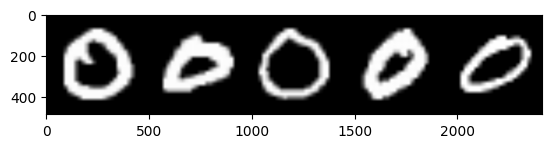

In [9]:
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

num_images_to_show = 5
print('Labels:', ' '.join(f'{labels[j].item()}' for j in range(num_images_to_show)))

imshow(torchvision.utils.make_grid(images[:num_images_to_show]))

In [10]:
folder = r'/content/drive/MyDrive/Model/data/Normal'
file_path = glob.glob(os.path.join(folder, "*.jpg"))

In [11]:
train_size = int(0.8 * len(file_path))
test_size = len(file_path) - train_size

full_dataset = CustomDataset(root_dir=folder, transform=CFG.transform)

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [12]:
train_loader = DataLoader(dataset=train_dataset, batch_size=CFG.batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=CFG.batch_size, shuffle=False)

In [13]:
neuralnet = nnet(height=CFG.height, width=CFG.width, channel=CFG.channel,
                 device=CFG.device, ngpu=CFG.ngpu)

The number of parameters: 25337.0000


In [14]:
summary(neuralnet.encoder, input_size=(32, 1, 480, 480), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [32, 16, 5, 5]            --
├─Sequential: 1-1                        [32, 16, 5, 5]            --
│    └─Conv2d: 2-1                       [32, 4, 480, 480]         40
│    └─ELU: 2-2                          [32, 4, 480, 480]         --
│    └─Conv2d: 2-3                       [32, 4, 480, 480]         148
│    └─ELU: 2-4                          [32, 4, 480, 480]         --
│    └─MaxPool2d: 2-5                    [32, 4, 240, 240]         --
│    └─Conv2d: 2-6                       [32, 8, 240, 240]         296
│    └─ELU: 2-7                          [32, 8, 240, 240]         --
│    └─Conv2d: 2-8                       [32, 8, 240, 240]         584
│    └─ELU: 2-9                          [32, 8, 240, 240]         --
│    └─MaxPool2d: 2-10                   [32, 8, 60, 60]           --
│    └─Conv2d: 2-11                      [32, 16, 60, 60]          1,168
│    └─EL

In [15]:
summary(neuralnet.decoder, input_size=(32, 16, 5, 5), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [32, 1, 480, 480]         --
├─Sequential: 1-1                        [32, 16, 5, 5]            --
│    └─Conv2d: 2-1                       [32, 16, 5, 5]            2,320
│    └─ELU: 2-2                          [32, 16, 5, 5]            --
├─Sequential: 1-2                        [32, 1, 480, 480]         --
│    └─Conv2d: 2-3                       [32, 16, 5, 5]            2,320
│    └─ELU: 2-4                          [32, 16, 5, 5]            --
│    └─Conv2d: 2-5                       [32, 16, 5, 5]            2,320
│    └─ELU: 2-6                          [32, 16, 5, 5]            --
│    └─Upsample: 2-7                     [32, 16, 15, 15]          --
│    └─Conv2d: 2-8                       [32, 16, 15, 15]          2,320
│    └─ELU: 2-9                          [32, 16, 15, 15]          --
│    └─Conv2d: 2-10                      [32, 16, 15, 15]          2,320


In [16]:
def pretrain(neuralnet, train_loader, epochs):
    neuralnet.train(mode=True)
    best_loss = float('inf')  # Initialize best loss to a very high value

    for epoch in range(epochs):
        num_batches = len(train_loader)

        for i, (inputs, _) in enumerate(train_loader):
            input = inputs.to(CFG.device)
            conv_out = neuralnet.encoder(input)
            x_hat = neuralnet.decoder(conv_out)
            loss = loss_function(
                x=input, x_hat=x_hat
            )

            loss.backward()
            neuralnet.optimizer.step()
            neuralnet.optimizer.zero_grad()

            # Check if the current batch loss is the best we've seen so far
            if loss.item() < best_loss:
                best_loss = loss.item()
                print(f'New best model found at epoch {epoch + 1}, batch {i + 1}, saving model.')
                print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{num_batches}], Loss: {loss.item()}')
                # print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{num_batches}], Loss: {loss.item():.4f}, '
                #       f'Restore_error: {restore_error:.4f}, KL-Divergence: {kl_divergence:.6f}')
                torch.save(neuralnet.encoder.state_dict(), 'vae_encoder_best.pth')
                torch.save(neuralnet.decoder.state_dict(), 'vae_decoder_best.pth')

            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{num_batches}], Loss: {loss.item()}')


In [17]:
neuralnet.to(CFG.device)
weight_device = neuralnet.encoder.encoder_conv[0].weight.device
print("Weight tensor of device:", weight_device)

Weight tensor of device: cuda:0


In [ ]:
 pretrain(neuralnet=neuralnet, train_loader=train_loader, epochs=50)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


New best model found at epoch 1, batch 1, saving model.
Epoch [1/50], Step [1/93], Loss: 0.2079688459634781
New best model found at epoch 1, batch 3, saving model.
Epoch [1/50], Step [3/93], Loss: 0.19330979883670807
New best model found at epoch 1, batch 4, saving model.
Epoch [1/50], Step [4/93], Loss: 0.19050312042236328
New best model found at epoch 1, batch 5, saving model.
Epoch [1/50], Step [5/93], Loss: 0.18281419575214386
New best model found at epoch 1, batch 6, saving model.
Epoch [1/50], Step [6/93], Loss: 0.17581015825271606
New best model found at epoch 1, batch 7, saving model.
Epoch [1/50], Step [7/93], Loss: 0.1559016853570938
New best model found at epoch 1, batch 8, saving model.
Epoch [1/50], Step [8/93], Loss: 0.1347154676914215
New best model found at epoch 1, batch 9, saving model.
Epoch [1/50], Step [9/93], Loss: 0.12293262034654617
New best model found at epoch 1, batch 10, saving model.
Epoch [1/50], Step [10/93], Loss: 0.10096272826194763
Epoch [1/50], Step [

KeyboardInterrupt: 

In [ ]:
def load_pretrained_model(encoder_path, decoder_path, device):
    neuralnet = nnet(height=CFG.height, width=CFG.width, channel=CFG.channel, device=CFG.device, ngpu=CFG.ngpu)
    neuralnet.encoder.load_state_dict(torch.load(encoder_path))
    neuralnet.decoder.load_state_dict(torch.load(decoder_path))
    return neuralnet

def calculate_heatmap(img, reconstructed_img):
    img_pil = to_pil_image(img.squeeze())
    reconstructed_img_pil = to_pil_image(reconstructed_img.squeeze())

    img_np = np.array(img_pil)
    reconstructed_img_np = np.array(reconstructed_img_pil)

    heatmap = np.zeros_like(img_np, dtype=np.float32)

    for i in range(img_np.shape[0]):
        for j in range(img_np.shape[1]):
            heatmap[i, j] = math.sqrt(math.pow(img_np[i, j] - reconstructed_img_np[i, j], 2))

    heatmap_tensor = torch.tensor(heatmap)
    return heatmap_tensor

def plot_histogram(heatmap_tensor):
    heatmap_np = heatmap_tensor.numpy()
    plt.hist(heatmap_np.ravel(), bins=256, range=(0.0, 0.1), fc='k', ec='k')
    plt.title("Histogram of Heatmap Values")
    plt.xlabel("Pixel Intensity Difference")
    plt.ylabel("Frequency")
    plt.ylim(0, 100)
    plt.show()

def plot_heatmap(heatmap_tensor):
    heatmap_np = heatmap_tensor.numpy()
    plt.imshow(heatmap_np, cmap='Reds')
    plt.colorbar()
    plt.title("Heatmap of Pixel Intensity Differences")
    plt.show()

def show_image(img):
    img = img.squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.show()

vae = load_pretrained_model('/content/drive/MyDrive/Model/notebook/py/vae_encoder_best.pth', '/content/drive/MyDrive/Model/notebook/py/vae_decoder_best.pth', CFG.device)
vae.encoder.eval()
vae.decoder.eval()

# MNIST 데이터셋에서 0번 클래스가 아닌 다른 클래스의 이미지를 로드
mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=CFG.transform)
loader = DataLoader(mnist, batch_size=1, shuffle=True)

images = []
for img, label in loader:
  if label.item() == 0:
    images.append(img.to(CFG.device))
    break

for idx, (img, label) in enumerate(loader):
        images.append(img.to(CFG.device))
        if idx == 10:
          break

for img in images:
  with torch.no_grad():
    conv_out = vae.encoder(img)
    reconstructed_img = vae.decoder(conv_out)

  print("Reconstructed Image:")
  show_image(reconstructed_img)

  print("Original Image:")
  show_image(img)

  heatmap = calculate_heatmap(img, reconstructed_img)
  plot_heatmap(heatmap)
  plot_histogram(heatmap)

Output hidden; open in https://colab.research.google.com to view.

In [18]:
training_and_testing(neuralnet=neuralnet ,train_dataset=train_dataset, test_dataset= test_dataset,
                      epochs=CFG.epochs, batch_size=CFG.batch_size)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1], Step [1/11], Total Loss: 0.06590913981199265
Epoch [1], Step [11/11], Total Loss: 0.03014407306909561
Epoch [1/15], Total Iteration: 11, Total Loss: 0.0445
Epoch [2], Step [1/11], Total Loss: 0.02647700347006321
Epoch [2], Step [11/11], Total Loss: 0.026365678757429123
Epoch [2/15], Total Iteration: 22, Total Loss: 0.0278
Epoch [3], Step [1/11], Total Loss: 0.02662414126098156
Epoch [3], Step [11/11], Total Loss: 0.018927039578557014
Epoch [3/15], Total Iteration: 33, Total Loss: 0.0228
Epoch [4], Step [1/11], Total Loss: 0.01808767020702362
Epoch [4], Step [11/11], Total Loss: 0.01275104284286499
Epoch [4/15], Total Iteration: 44, Total Loss: 0.0152
Epoch [5], Step [1/11], Total Loss: 0.01185663416981697
Epoch [5], Step [11/11], Total Loss: 0.011579361744225025
Epoch [5/15], Total Iteration: 55, Total Loss: 0.0116
Epoch [6], Step [1/11], Total Loss: 0.012013602070510387
Epoch [6], Step [11/11], Total Loss: 0.010418211109936237
Epoch [6/15], Total Iteration: 66, Total Loss: 

In [32]:
def load_pretrained_model(encoder_path, decoder_path, device):
    neuralnet = nnet(height=CFG.height, width=CFG.width, channel=CFG.channel, device=CFG.device, ngpu=CFG.ngpu)
    neuralnet.encoder.load_state_dict(torch.load(encoder_path))
    neuralnet.decoder.load_state_dict(torch.load(decoder_path))
    return neuralnet

def calculate_heatmap(img, reconstructed_img):
    img_pil = to_pil_image(img.squeeze())
    reconstructed_img_pil = to_pil_image(reconstructed_img.squeeze())

    img_np = np.array(img_pil)
    reconstructed_img_np = np.array(reconstructed_img_pil)

    heatmap = np.zeros_like(img_np, dtype=np.float32)

    for i in range(img_np.shape[0]):
        for j in range(img_np.shape[1]):
            heatmap[i, j] = math.sqrt(math.pow(img_np[i, j] - reconstructed_img_np[i, j], 2))

    heatmap_tensor = torch.tensor(heatmap)
    return heatmap_tensor

def plot_histogram(heatmap_tensor):
    heatmap_np = heatmap_tensor.numpy()
    plt.hist(heatmap_np.ravel(), bins=256, range=(0.0, 0.1), fc='k', ec='k')
    plt.title("Histogram of Heatmap Values")
    plt.xlabel("Pixel Intensity Difference")
    plt.ylabel("Frequency")
    plt.ylim(0, 100)
    plt.show()

def plot_heatmap(heatmap_tensor):
    heatmap_np = heatmap_tensor.numpy()
    plt.imshow(heatmap_np, cmap='Reds')
    plt.colorbar()
    plt.title("Heatmap of Pixel Intensity Differences")
    plt.show()

def show_image(img):
    img = img.squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.show()

vae = load_pretrained_model('/content/drive/MyDrive/Model/notebook/py/results/encoder_epoch_15.pth', '/content/drive/MyDrive/Model/notebook/py/results/decoder_epoch_15.pth', CFG.device)
vae.encoder.eval()
vae.decoder.eval()

test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

images = []

for idx, img in enumerate(test_loader):
    images.append(img[0].to(CFG.device))
    if idx == 10:
      break

for img in images:
  with torch.no_grad():
    conv_out = vae.encoder(img)
    reconstructed_img = vae.decoder(conv_out)

  print("Reconstructed Image:")
  show_image(reconstructed_img)

  print("Original Image:")
  show_image(img)

  heatmap = calculate_heatmap(img, reconstructed_img)
  plot_heatmap(heatmap)
  plot_histogram(heatmap)